In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats


In [2]:
# Load data
data = pd.read_csv('./labeled_data.csv')
data.dropna(subset=['Label'], inplace=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      627 non-null    object
 1   NDVI    627 non-null    object
 2   NBR     627 non-null    object
 3   Label   627 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 19.7+ KB


In [3]:
# Split data into training and test set
data['NBR'] = data['NBR'].apply(lambda x: pd.eval(x, local_dict={'nan': np.nan}))
data['NDVI'] = data['NDVI'].apply(lambda x: pd.eval(x, local_dict={'nan': np.nan}))
data.head()


,ID,NDVI,NBR,Label
0,20230813_100,"[0.7755693773142729, 0.8109320515721594, 0.851...","[0.003078832689977299, 0.049812837737360276, 0...",1
1,20230813_101,"[0.34495916148451133, 0.24291931815932866, 0.2...","[0.05116118296949416, -0.026290510714717576, 0...",2
2,20230813_102,"[0.8418304439153839, 0.798698150698662, 0.8062...","[0.058663947405941635, 0.04357172884127514, 0....",1
3,20230813_103,"[0.5716647915500211, 0.5872206605870187, 0.589...","[0.019482128930850738, 0.009917857640267346, 0...",2
4,20230813_104,"[-0.2217794764351386, -0.22595804483580587, -0...","[0.006908720294918405, 0.00880010401111331, -0...",0


In [4]:
# Combine NBR and NDVI data into a single feature array
# Flatten each sublist and concatenate NBR and NDVI for each row
X = np.array([np.ravel(nbr + ndvi) for nbr, ndvi in zip(data['NBR'], data['NDVI'])])
X = np.nan_to_num(X)

# Labels
y = data['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [5]:
# Initialize and train the Naive Bayes model
clf = GaussianNB()
clf.fit(X_train, y_train)


GaussianNB()

In [6]:
# Fine-tuning the model using Grid Search
param_grid = {'var_smoothing': np.logspace(0,-9,num=100)}
grid_search = GridSearchCV(estimator=clf,param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ....................var_smoothing=0.657933224657568; total time=   0.0s
[CV] END ....................var_smoothing=0.533669923120631; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ....................var_smoothing=0.533669923120631; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ....................var_smoothing=0.533669923120631; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ..................var_smoothing=0.43287612810830584; total time=   0.0s
[CV] END ..................var_smoothing=0.432

In [7]:
# Make predictions using the fine-tuned model
# Calculate model efficiency

y_pred = clf.predict(X_test)


In [10]:
# Evaluate the fine-tuned model

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
map_score = average_precision_score(y_test, y_pred.reshape(-1, 1), average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Mean Average Precision: {map_score:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.4656
Precision: 0.3787
Recall: 0.3873
Mean Average Precision: 0.4291

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.45      0.51        86
           1       0.43      0.69      0.53        62
           2       0.18      0.07      0.10        29
           3       0.31      0.33      0.32        12

    accuracy                           0.47       189
   macro avg       0.38      0.39      0.37       189
weighted avg       0.46      0.47      0.44       189


Confusion Matrix:
[[39 37  3  7]
 [15 43  3  1]
 [10 16  2  1]
 [ 2  3  3  4]]


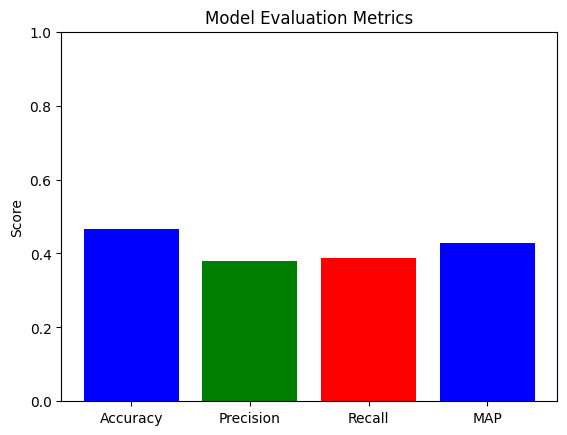

In [11]:

# Visualize the model evaluation metrics

metrics = ['Accuracy', 'Precision', 'Recall', 'MAP']
values = [accuracy, precision, recall, map_score]

plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1)  # to set y-axis limits from 0 to 1
plt.show()
